In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

In [2]:
df = pd.read_csv('master_df.csv')

In [3]:
opening_odds_columns = df.filter(like='opening').columns
opening_odds_df = df[opening_odds_columns]
opening_odds_df

,betmgm_opening_homeOdds,betmgm_opening_awayOdds,fanduel_opening_homeOdds,fanduel_opening_awayOdds,caesars_opening_homeOdds,caesars_opening_awayOdds,bet365_opening_homeOdds,bet365_opening_awayOdds,draftkings_opening_homeOdds,draftkings_opening_awayOdds
0,-190.0,155.0,-190.0,160.0,-179.0,160.0,-192.0,167.0,-170.0,150.0
1,-185.0,150.0,-190.0,160.0,-161.0,140.0,-170.0,150.0,-160.0,140.0
2,-225.0,180.0,-220.0,184.0,-222.0,190.0,-220.0,180.0,-155.0,135.0
3,-250.0,200.0,-250.0,205.0,-256.0,215.0,-260.0,215.0,-220.0,180.0
4,-105.0,-115.0,-102.0,-116.0,105.0,-125.0,105.0,-125.0,105.0,-125.0
...,...,...,...,...,...,...,...,...,...,...
2346,-210.0,170.0,-190.0,160.0,-196.0,162.0,-190.0,160.0,-205.0,170.0
2347,-135.0,110.0,-126.0,108.0,-130.0,110.0,-130.0,110.0,-130.0,110.0
2348,100.0,-120.0,-104.0,-112.0,100.0,-120.0,100.0,-120.0,102.0,-122.0
2349,-250.0,200.0,-270.0,220.0,-233.0,192.0,-230.0,190.0,-238.0,195.0


In [3]:
def american_to_implied_prob(odds):
    """Convert American odds to implied probability (with vig)."""
    return 100 / (odds + 100) if odds > 0 else -odds / (-odds + 100)

def add_fair_implied_probs(df):
    odds_columns = [
        'betmgm_opening_homeOdds', 'betmgm_opening_awayOdds',
        'fanduel_opening_homeOdds', 'fanduel_opening_awayOdds',
        'caesars_opening_homeOdds', 'caesars_opening_awayOdds',
        'bet365_opening_homeOdds', 'bet365_opening_awayOdds',
        'draftkings_opening_homeOdds', 'draftkings_opening_awayOdds'
    ]
    
    for i in range(0, len(odds_columns), 2):
        home_col = odds_columns[i]
        away_col = odds_columns[i+1]

        home_prob = df[home_col].apply(american_to_implied_prob)
        away_prob = df[away_col].apply(american_to_implied_prob)

        total_prob = home_prob + away_prob

        # Use .loc to avoid SettingWithCopyWarning
        df.loc[:, home_col.replace('Odds', 'FairProb')] = home_prob / total_prob
        df.loc[:, away_col.replace('Odds', 'FairProb')] = away_prob / total_prob

    return df

odds_df = add_fair_implied_probs(df)

In [4]:
def create_beta_prior(df):
    fair_prob_cols = [
        'betmgm_opening_homeFairProb',
        'fanduel_opening_homeFairProb',
        'caesars_opening_homeFairProb',
        'bet365_opening_homeFairProb',
        'draftkings_opening_homeFairProb'
    ]

    # Alpha: sum of home fair probs
    df['beta_alpha'] = df[fair_prob_cols].sum(axis=1)
    # Beta: sum of (1 - home fair probs)
    df['beta_beta'] = len(fair_prob_cols) - df['beta_alpha']

    # Optional: posterior mean for reference
    df['beta_mean'] = df['beta_alpha'] / (df['beta_alpha'] + df['beta_beta'])

    return df

beta_priors = create_beta_prior(odds_df)
beta_priors

,gameId,startDate,homeTeam,awayTeam,homePitcher,awayPitcher,homeScore,awayScore,betmgm_opening_homeOdds,betmgm_opening_awayOdds,...,fanduel_opening_awayFairProb,caesars_opening_homeFairProb,caesars_opening_awayFairProb,bet365_opening_homeFairProb,bet365_opening_awayFairProb,draftkings_opening_homeFairProb,draftkings_opening_awayFairProb,beta_alpha,beta_beta,beta_mean
0,259014,2022-05-21T00:10:00+00:00,Milwaukee,Washington,Eric Lauer,Erick Fedde,7,0,-190.0,155.0,...,0.369898,0.625202,0.374798,0.637105,0.362895,0.611511,0.388489,3.129484,1.870516,0.625897
1,259007,2022-05-21T00:10:00+00:00,Houston,Texas,Cristian Javier,Martin Perez,0,3,-185.0,150.0,...,0.369898,0.596849,0.403151,0.611511,0.388489,0.596273,0.403727,3.053464,1.946536,0.610693
2,259026,2022-05-21T17:05:00+00:00,NY Yankees,Chi. White Sox,Nestor Cortes,Dallas Keuchel,7,5,-225.0,180.0,...,0.338696,0.666598,0.333402,0.658120,0.341880,0.588212,0.411788,3.233919,1.766081,0.646784
3,259023,2022-05-21T19:07:00+00:00,Toronto,Cincinnati,Alek Manoah,Hunter Greene,3,1,-250.0,200.0,...,0.314607,0.693737,0.306263,0.694656,0.305344,0.658120,0.341880,3.413725,1.586275,0.682745
4,265633,2022-05-21T19:10:00+00:00,Colorado,NY Mets,German Marquez,Carlos Carrasco,1,5,-105.0,-115.0,...,0.515397,0.467532,0.532468,0.467532,0.532468,0.467532,0.532468,2.376366,2.623634,0.475273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,301021,2024-08-21T00:10:00+00:00,Kansas City,LA Angels,Cole Ragans,Tyler Anderson,5,9,-210.0,170.0,...,0.369898,0.634351,0.365649,0.630102,0.369898,0.644729,0.355271,3.185807,1.814193,0.637161
2347,301022,2024-08-21T00:10:00+00:00,Houston,Boston,Ronel Blanco,Nick Pivetta,5,6,-135.0,110.0,...,0.463039,0.542744,0.457256,0.542744,0.457256,0.542744,0.457256,2.711961,2.288039,0.542392
2348,301034,2024-08-21T01:40:00+00:00,San Diego,Minnesota,Martin Perez,Bailey Ober,7,5,100.0,-120.0,...,0.508909,0.478261,0.521739,0.478261,0.521739,0.473913,0.526087,2.399787,2.600213,0.479957
2349,301025,2024-08-21T01:45:00+00:00,San Francisco,Chi. White Sox,Robbie Ray,Davis Martin,4,1,-250.0,200.0,...,0.299838,0.671390,0.328610,0.669007,0.330993,0.675031,0.324969,3.397409,1.602591,0.679482


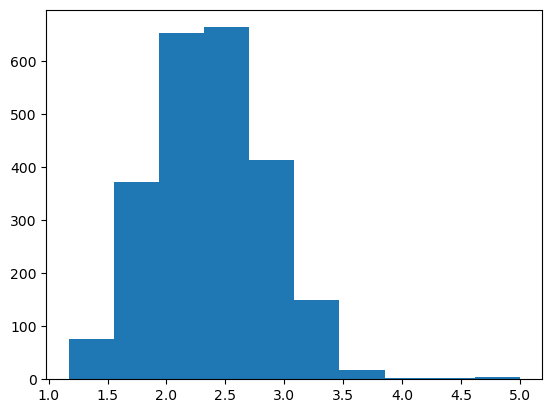

In [6]:
plt.hist(beta_priors['beta_beta'])
plt.show()

This looks okay, given that we are only looking at home team winning percentage which should slightly be skewed above 50%

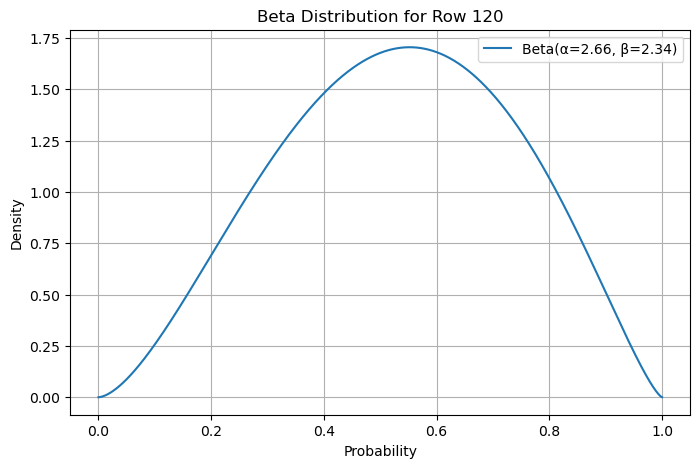

In [12]:
def plot_beta_distribution(df, index):
    alpha = df.loc[index, 'beta_alpha']
    beta_param = df.loc[index, 'beta_beta']
    
    x = np.linspace(0, 1, 1000)
    y = beta.pdf(x, alpha, beta_param)

    plt.figure(figsize=(8, 5))
    plt.plot(x, y, label=f'Beta(α={alpha:.2f}, β={beta_param:.2f})')
    plt.title(f'Beta Distribution for Row {index}')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_beta_distribution(beta_priors, 120)

In [15]:
df

,gameId,startDate,homeTeam,awayTeam,homePitcher,awayPitcher,homeScore,awayScore,betmgm_opening_homeOdds,betmgm_opening_awayOdds,...,fanduel_opening_awayFairProb,caesars_opening_homeFairProb,caesars_opening_awayFairProb,bet365_opening_homeFairProb,bet365_opening_awayFairProb,draftkings_opening_homeFairProb,draftkings_opening_awayFairProb,beta_alpha,beta_beta,beta_mean
0,259014,2022-05-21T00:10:00+00:00,Milwaukee,Washington,Eric Lauer,Erick Fedde,7,0,-190.0,155.0,...,0.369898,0.625202,0.374798,0.637105,0.362895,0.611511,0.388489,3.129484,1.870516,0.625897
1,259007,2022-05-21T00:10:00+00:00,Houston,Texas,Cristian Javier,Martin Perez,0,3,-185.0,150.0,...,0.369898,0.596849,0.403151,0.611511,0.388489,0.596273,0.403727,3.053464,1.946536,0.610693
2,259026,2022-05-21T17:05:00+00:00,NY Yankees,Chi. White Sox,Nestor Cortes,Dallas Keuchel,7,5,-225.0,180.0,...,0.338696,0.666598,0.333402,0.658120,0.341880,0.588212,0.411788,3.233919,1.766081,0.646784
3,259023,2022-05-21T19:07:00+00:00,Toronto,Cincinnati,Alek Manoah,Hunter Greene,3,1,-250.0,200.0,...,0.314607,0.693737,0.306263,0.694656,0.305344,0.658120,0.341880,3.413725,1.586275,0.682745
4,265633,2022-05-21T19:10:00+00:00,Colorado,NY Mets,German Marquez,Carlos Carrasco,1,5,-105.0,-115.0,...,0.515397,0.467532,0.532468,0.467532,0.532468,0.467532,0.532468,2.376366,2.623634,0.475273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,301021,2024-08-21T00:10:00+00:00,Kansas City,LA Angels,Cole Ragans,Tyler Anderson,5,9,-210.0,170.0,...,0.369898,0.634351,0.365649,0.630102,0.369898,0.644729,0.355271,3.185807,1.814193,0.637161
2347,301022,2024-08-21T00:10:00+00:00,Houston,Boston,Ronel Blanco,Nick Pivetta,5,6,-135.0,110.0,...,0.463039,0.542744,0.457256,0.542744,0.457256,0.542744,0.457256,2.711961,2.288039,0.542392
2348,301034,2024-08-21T01:40:00+00:00,San Diego,Minnesota,Martin Perez,Bailey Ober,7,5,100.0,-120.0,...,0.508909,0.478261,0.521739,0.478261,0.521739,0.473913,0.526087,2.399787,2.600213,0.479957
2349,301025,2024-08-21T01:45:00+00:00,San Francisco,Chi. White Sox,Robbie Ray,Davis Martin,4,1,-250.0,200.0,...,0.299838,0.671390,0.328610,0.669007,0.330993,0.675031,0.324969,3.397409,1.602591,0.679482


In [13]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split

# ------------------------------
# Data Preparation
# ------------------------------
# Ensure numeric types
df = beta_priors

df['alpha'] = pd.to_numeric(df['alpha'], errors='coerce')
df['beta'] = pd.to_numeric(df['beta'], errors='coerce')
df['gamma'] = pd.to_numeric(df['gamma'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Filter out invalid rows
df_clean = df[np.isfinite(df['alpha']) & np.isfinite(df['beta']) & np.isfinite(df['gamma']) & np.isfinite(df['X'])].copy()
df_clean = df_clean.reset_index(drop=True)

# ------------------------------
# Train/Validation Split
# ------------------------------
train_df, val_df = train_test_split(df_clean, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# ------------------------------
# Extract Train Data
# ------------------------------
alpha_data = np.clip(train_df['alpha'].astype(float).values, 1e-6, None)
beta_data = np.clip(train_df['beta'].astype(float).values, 1e-6, None)
gamma_data = np.clip(train_df['gamma'].astype(float).values, 0.2, 5)
X_data = train_df['X'].astype(int).values

# ------------------------------
# PyMC Model with Uniform m
# ------------------------------
with pm.Model() as model:
    # Priors on exponents
    r1 = pm.Uniform('r1', lower=-1, upper=4)
    r2 = pm.Uniform('r2', lower=-4, upper=4)
    r3 = pm.Uniform('r3', lower=-1, upper=4)
    delta = pm.Uniform('delta', lower=0, upper=4)

    # Prior for log_m, exponentiated and clipped to avoid explosion
    log_m = pm.Normal("log_m", mu=2.5, sigma=1.0)
    m = pm.Deterministic("m", pm.math.minimum(pm.math.exp(log_m), 50.0))

    # Relative strength
    lambda_ = alpha_data ** r1 * beta_data ** r2 * gamma_data ** r3
    lambda_delta = lambda_ * delta

    # Beta shape parameters
    a = pm.Deterministic("a", m * lambda_delta)
    b = pm.Deterministic("b", m)

    # Win probability
    p_s = pm.Beta('p_s', alpha=a, beta=b, shape=len(X_data))

    # Likelihood
    X_obs = pm.Bernoulli('X_obs', p=p_s, observed=X_data)

    # Sample
    trace = pm.sample(
        draws=1000,
        tune=500,
        target_accept=0.95,
        cores=4,
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r1, r2, r3, delta, log_m, p_s]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [14]:
import numpy as np

def predict_win_probability_from_trace(trace, alpha, beta, gamma):
    """
    Predict posterior win probabilities using a trained PyMC trace 
    and new alpha, beta, gamma inputs.
    
    Parameters:
        trace: ArviZ InferenceData object (from pm.sample)
        alpha, beta, gamma: np.arrays of shape (n_games,)
    
    Returns:
        p_mean: Posterior mean win probabilities (n_games,)
        p_samples: Posterior samples (n_samples, n_games)
    """
    posterior = trace.posterior
    r1 = posterior['r1'].stack(sample=("chain", "draw")).values
    r2 = posterior['r2'].stack(sample=("chain", "draw")).values
    r3 = posterior['r3'].stack(sample=("chain", "draw")).values
    delta = posterior['delta'].stack(sample=("chain", "draw")).values
    m = posterior['m'].stack(sample=("chain", "draw")).values

    n_samples = len(r1)
    n_games = len(alpha)

    # Expand new data
    alpha_exp = np.tile(alpha, (n_samples, 1))
    beta_exp = np.tile(beta, (n_samples, 1))
    gamma_exp = np.tile(gamma, (n_samples, 1))

    # Forward pass
    lambda_ = (alpha_exp ** r1[:, None]) * (beta_exp ** r2[:, None]) * (gamma_exp ** r3[:, None])
    lambda_delta = lambda_ * delta[:, None]

    a = m[:, None] * lambda_delta
    b = m[:, None]

    # Posterior win probabilities
    p_samples = np.random.beta(a, b)
    p_mean = p_samples.mean(axis=0)

    return p_mean, p_samples

# Prepare validation data
val_alpha = np.clip(val_df['alpha'].astype(float).values, 1e-6, None)
val_beta = np.clip(val_df['beta'].astype(float).values, 1e-6, None)
val_gamma = np.clip(val_df['gamma'].astype(float).values, 0.2, 5)

# Get predictions
p_mean, p_samples = predict_win_probability_from_trace(trace, val_alpha, val_beta, val_gamma)

# Binary score (hard and soft)
val_X = val_df['X'].astype(int).values
p_hard = (p_mean > 0.5).astype(int)

score_hard = 1 - np.mean((p_hard - val_X) ** 2)
score_soft = 1 - np.mean((p_mean - val_X) ** 2)

print("Validation Score (Hard):", score_hard)
print("Validation Score (Soft):", score_soft)

Validation Score (Hard): 0.5721040189125295
Validation Score (Soft): 0.7601324504235829
